In [28]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

from plotting import EnsemblePlot
import forestprune



### Load CTR dataset

In [19]:
np.random.seed(42)

#load data
ctr = pd.read_csv('data/CTR.csv')
ctr = pd.get_dummies(ctr, columns=['gender','age'])

y = ctr['CTR']
X = ctr.drop('CTR',axis = 1)

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.33)
xscaler = preprocessing.StandardScaler()
xTrain = xscaler.fit_transform(xTrain)
xTrain = pd.DataFrame(xTrain,columns = X.columns)
xTest = xscaler.transform(xTest)
xTest = pd.DataFrame(xTest,columns = X.columns)
yscaler = preprocessing.StandardScaler()

yTrain = yscaler.fit_transform(yTrain.values.reshape(-1, 1))
yTest = yscaler.transform(yTest.values.reshape(-1, 1))
yTrain = pd.Series(yTrain.flatten())
yTrain.index = xTrain.index
yTest = pd.Series(yTest.flatten())
yTest.index = xTest.index

xTrain = xTrain.fillna(xTrain.median())
xTest = xTest.fillna(xTrain.median())


### Fit random forest

In [20]:
np.random.seed(42)
rf = RandomForestRegressor(n_estimators = 100, 
                           max_features = 'sqrt', max_depth = 8).fit(xTrain,yTrain)

rf_pred = rf.predict(xTest)
print('R-squared Deep Random Forest: ' , forestprune.r_squared(yTest,rf_pred,yTrain))
tree_list = rf.estimators_

R-squared Deep Random Forest:  0.4544356367276493


### Visualize first 10 trees in Random Forest

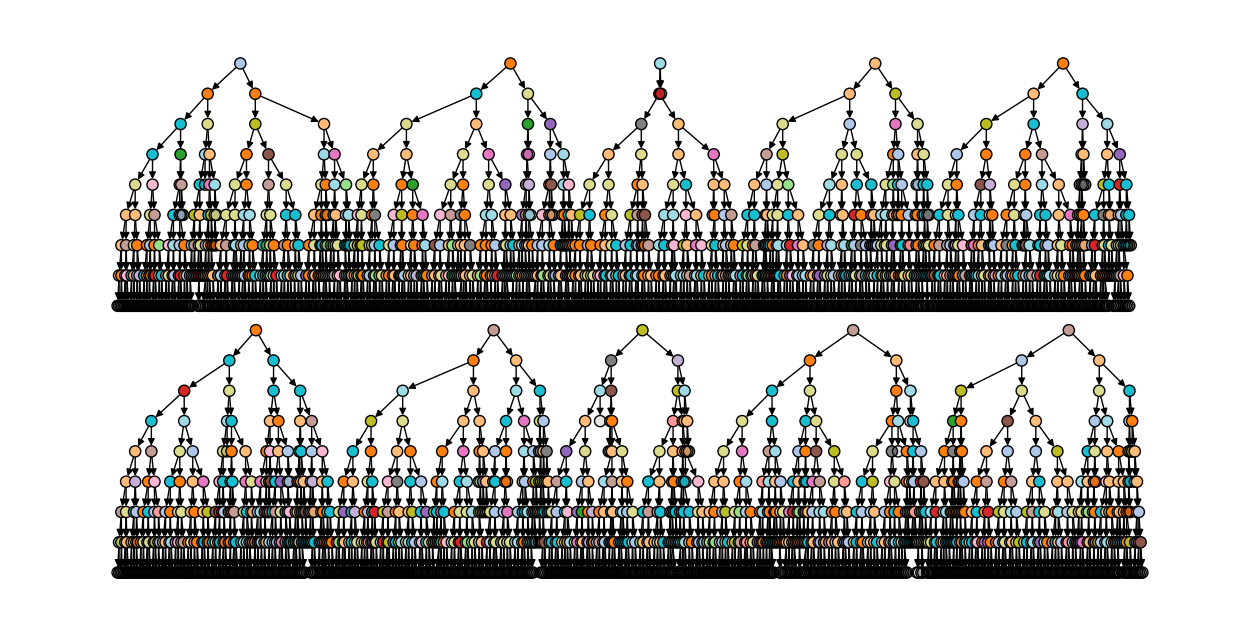

In [21]:
L1 = np.arange(len(xTrain.columns))
L2 = xTrain.columns
feature_names = {k:v for k,v in zip(L1,L2)}
feature_names[-2] = 'leaf'
ep = EnsemblePlot([],[],[],[])

G_all, graphs = ep.prune_ensemble_graph(tree_list[:10], np.ones(shape = (10,10)),feature_names, method = 'layers')
node_colors,cmap, legend_array = ep.get_colors(G_all, plot_legend = False)
mapping = legend_array[0]


scalarMap = legend_array[1]
pos1 = ep.pos_grid_layout(G_all, 2)


fig = plt.figure(figsize = (16,8))
ax = plt.subplot(111)
nx.draw(G_all,pos1,node_color = node_colors, 
        cmap = cmap,node_size = 65 , edgecolors = 'black' ,  with_labels = False)
for label in mapping:
    plt.plot([0],[0],color=scalarMap.to_rgba(mapping[label]),label=label,linewidth = 10)

plt.show()

This deep random forest is hard to interpret. The plot above shows the first 10 trees in the random forest; it is very difficult from this picture to determine how features impact the response.

# ForestPrune (shallow tree ensembles)

In [29]:
### preliminaries
np.random.seed(42)
tree_list = np.array(rf.estimators_)
W_array = forestprune.nodes_per_layer(tree_list)
normalization = forestprune.total_nodes(tree_list)

learning_rate = 1/len(tree_list)

base_err = sklearn.metrics.mean_squared_error(yTest,rf.predict(xTest))

base_rf_nodes = 0
for tree1 in tree_list:
    base_rf_nodes = base_rf_nodes + tree1.tree_.node_count

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diff_array_list = forestprune.difference_array_list(xTrain,tree_list)
    diff_test_array_list = forestprune.difference_array_list(xTest,tree_list)


In [30]:
%%time
np.random.seed(42)
alpha = 25
vars_best,_ = forestprune.solve_weighted(pd.Series(yTrain.values),tree_list,diff_array_list,alpha,learning_rate,
                            W_array,normalization,)
K = 10
coef_best = forestprune.prune_polish_l1(diff_array_list,yTrain,vars_best,learning_rate,K) #prune polish


CPU times: user 2.67 s, sys: 49.3 ms, total: 2.72 s
Wall time: 310 ms


In [31]:
pruned_err, pred_polish = forestprune.evaluate_test_error_polished(diff_test_array_list,yTest.values,vars_best,
                                                              coef_best,learning_rate)
print('R-squared ForestPrune: ' , forestprune.r_squared(yTest,pred_polish,yTrain)) #using the L0-prune-polish method in the full package yields better performance

R-squared ForestPrune:  0.3334155253711837


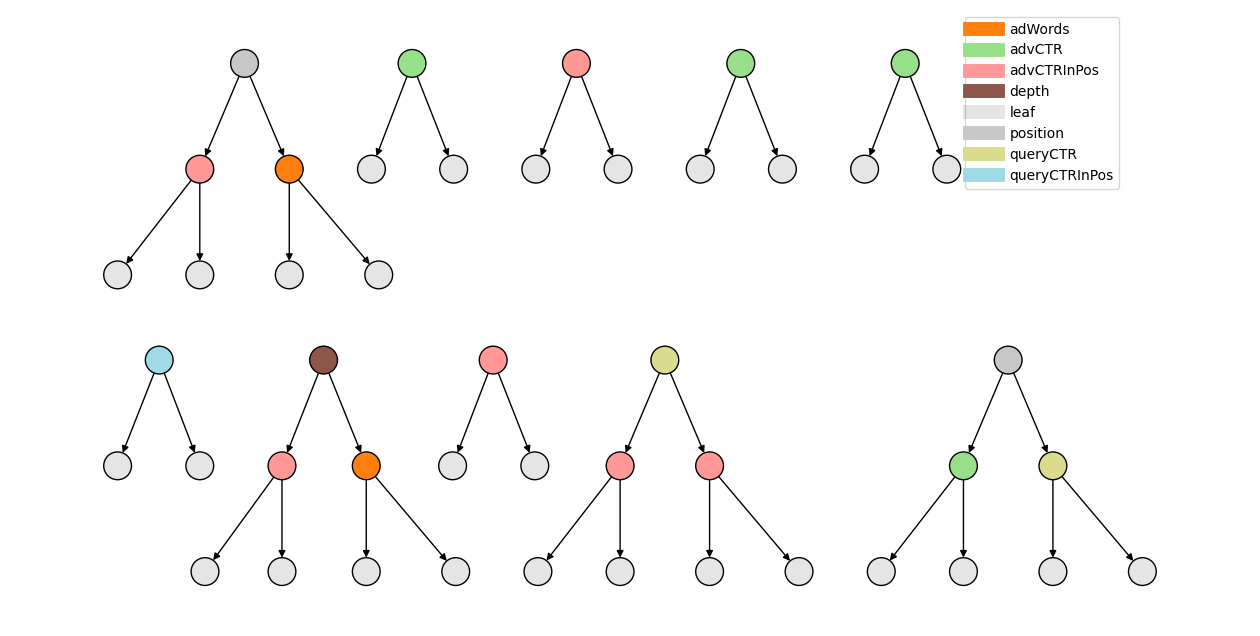

In [32]:

L1 = np.arange(len(xTrain.columns))
L2 = xTrain.columns
feature_names = {k:v for k,v in zip(L1,L2)}
feature_names[-2] = 'leaf'
ep = EnsemblePlot([],[],[],[])
trees_ordered = tree_list[[sum(i) != 0 for i in vars_best]][np.argsort(-np.abs(coef_best))]
vars_ordered = vars_best[[sum(i) != 0 for i in vars_best]][np.argsort(-np.abs(coef_best))]
coefs = -np.sort(-np.abs(coef_best))

G_all, graphs = ep.prune_ensemble_graph(trees_ordered[:K], vars_ordered[:K],feature_names, method = 'layers')


node_colors,cmap, legend_array = ep.get_colors(G_all, plot_legend = False)

mapping = legend_array[0]


scalarMap = legend_array[1]
pos1 = ep.pos_grid_layout(G_all, 2)



fig = plt.figure(figsize = (16,8))
ax = plt.subplot(111)
nx.draw(G_all,pos1,node_color = node_colors, 
        cmap = cmap,node_size = 400 , edgecolors = 'black' ,  with_labels = False)
for label in mapping:
    plt.plot([0],[0],color=scalarMap.to_rgba(mapping[label]),label=label,linewidth = 10)
    
#plt.legend( prop={'size': 12})
ax.legend(bbox_to_anchor=(.9, 1.))
plt.show()